In [1]:
from glob import glob
from pathlib import Path
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# total_steps = train_steps
# old_ts = total_steps
# rollout_number = 0
# for dir in os.listdir(raw_data_path):
#     if dir == ".DS_Store":
#         continue
    
#     path = raw_data_path + dir
#     os.system(f"python -m chem_data.chemgns --action='prepare' --raw_data_path={path}  --preped_data_path={npz_path}")
    
#     rollout_folder = rollouts_path + "rollout" + str(rollout_number)
#     os.system(f"mkdir -p {rollout_folder}")
#     rollout_number += 1
    
#     if total_steps == train_steps:
#         os.system(f"python -m gns.train --data_path={npz_path} --model_path={model_path} --output_path={rollout_folder} -ntraining_steps={total_steps}")
#     else:
#         os.system(f"python -m gns.train --data_path={npz_path} --model_path={model_path} --output_path={rollout_folder} " +
#                   f"--model_file='model-{old_ts}.pt' --train_state_file='train_state-{old_ts}.pt' -ntraining_steps={total_steps}")
        
#     os.system(f"python -m gns.train --mode='rollout' --data_path={npz_path} --model_path={model_path} --output_path={rollout_folder} " +
#               f"--model_file='model-{total_steps}.pt' --train_state_file='train_state-{total_steps}.pt'")
#     os.system(f"python -m chem_data.chemgns --action='analyze' --rollout_data_path={rollout_folder}  --proc_data_path={rollout_dicts}")
    
#     old_ts = total_steps
#     total_steps += train_steps

In [21]:
# raw_data_path = "./chem_data/processed_output_some/"
# topredict_path = "./chem_data/to_predict"
# rollout_dicts = "./chem_data/proc_data"

# npz_path = "./gns/data/"
# model_path = "./gns/model/"
# rollouts_path = "./gns/output/"

# train_steps = 300

In [22]:
#python -m chem_data.chemgns --action='predict' --raw_data_path="./chem_data/to_predict"  --preped_data_path="./gns/data/"
#python -m gns.train --mode="predict" --data_path="./gns/data/" --model_path="./gns/model/" --output_path="./gns/predicted_rollout" --model_file="model-300.pt" --train_state_file="train_state-300.pt"

# Check Results

In [2]:
import chem_data.analyze_results as ar

In [24]:
material_properties = ['BC', 'OC', 'aero_number']
particle_chems = ['H2O', 'SO4']
gases = ['H2SO4']

In [3]:
rollout_data = ar.load_rollout_data("./chem_data/proc_data")

In [4]:
ro = rollout_data['rollout_ex0_dict.pkl']

In [5]:
ro.keys()

dict_keys(['loss', 'true_x', 'pred_x', 'mat_prop'])

In [6]:
true_x = ro['true_x']
pred_x = ro['pred_x']
mat_prop = ro['mat_prop']

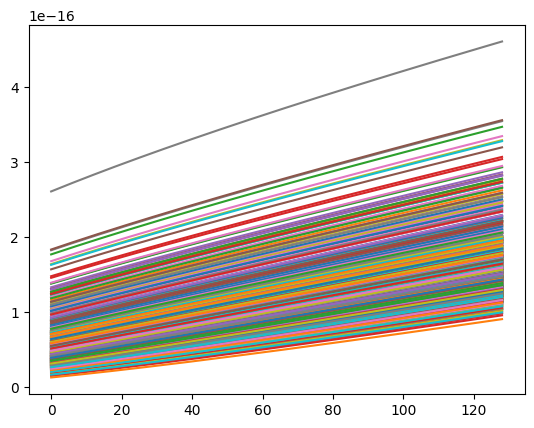

In [29]:
plt.plot(true_x['SO4'])
plt.show()

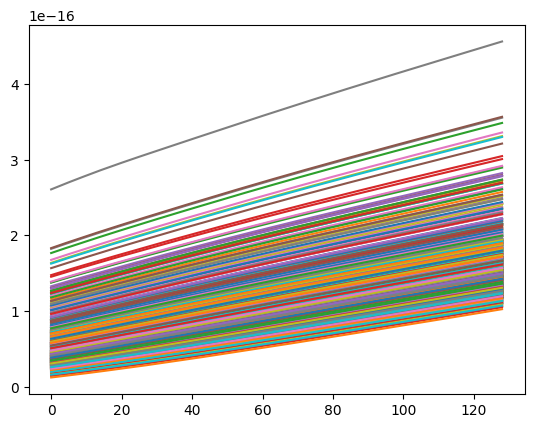

In [30]:
plt.plot(pred_x['SO4'])
plt.show()

In [52]:
ar.nmae(true_x['SO4'], pred_x['SO4'])

0.010542462243415601

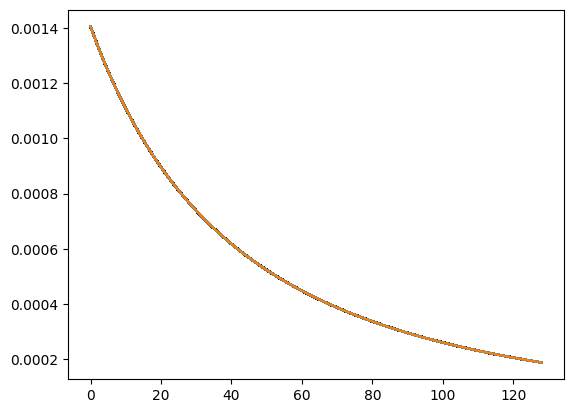

In [31]:
plt.plot(true_x['H2SO4'])
plt.show()

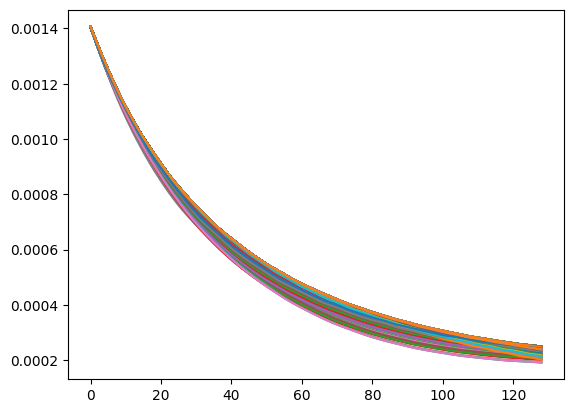

In [32]:
plt.plot(pred_x['H2SO4'])
plt.show()

In [53]:
ar.nmae(true_x['H2SO4'], pred_x['H2SO4'])

0.07626637234946422

In [9]:
true_dry_mass = {'BC': mat_prop['BC'], 'OC': mat_prop['OC'], 'SO4': true_x['SO4']}

In [10]:
pred_dry_mass = {'BC': mat_prop['BC'], 'OC': mat_prop['OC'], 'SO4': pred_x['SO4']}

In [35]:
so4_diam = ar.gd_from_vol(ar.volume('SO4', true_dry_mass))

In [36]:
pred_so4_diam = ar.gd_from_vol(ar.volume('SO4', pred_dry_mass))

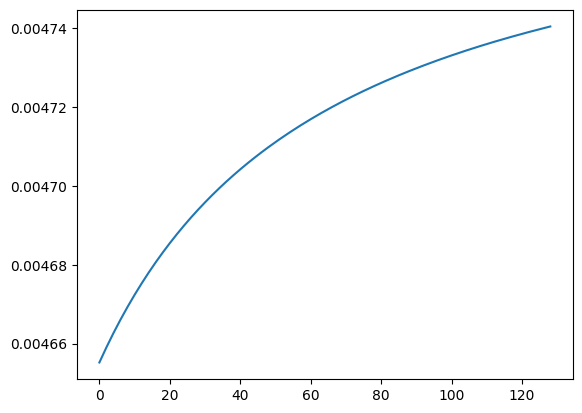

In [37]:
plt.plot(ar.mass_concentration(true_dry_mass, mat_prop['aero_number'], chem='all'))

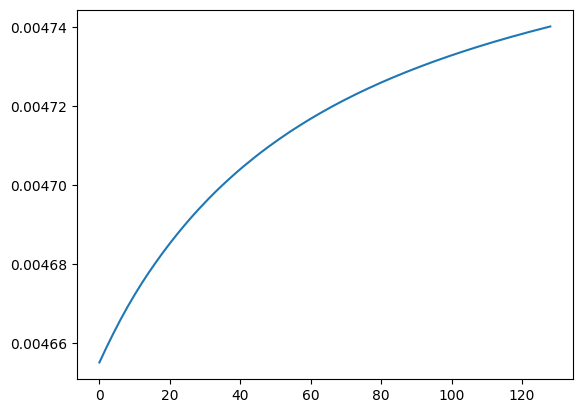

In [38]:
plt.plot(ar.mass_concentration(pred_dry_mass, mat_prop['aero_number'], chem='all'))

In [79]:
total_true_drymass = sum(true_dry_mass.values())

In [80]:
total_pred_drymass = sum(pred_dry_mass.values())

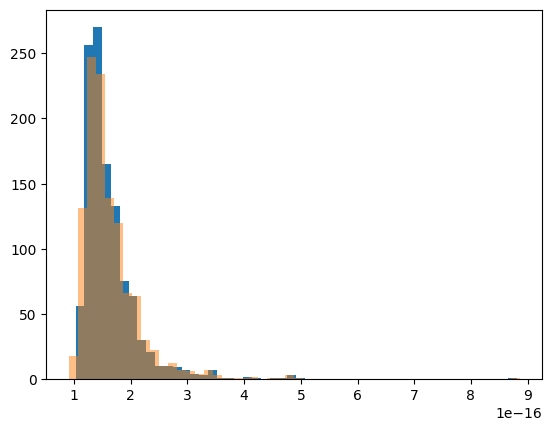

In [12]:
fig, ax = plt.subplots()
ax.hist(total_pred_drymass[-1,:], bins=50)
ax.hist(total_true_drymass[-1,:], bins=50, alpha=0.5)
plt.show()

In [42]:
mat_prop['aero_number'].shape

(129, 1132)

In [43]:
dNdt = mat_prop['aero_number'][1:,:] - mat_prop['aero_number'][:-1,:]

In [85]:
true_Ddry = ar.gd_from_vol(ar.volume('SO4', true_dry_mass) + ar.volume('BC', true_dry_mass) + ar.volume('SO4', true_dry_mass))

In [86]:
pred_Ddry = ar.gd_from_vol(ar.volume('SO4', pred_dry_mass) + ar.volume('BC', pred_dry_mass) + ar.volume('SO4', pred_dry_mass))

In [49]:
dDdrydt = Ddry[1:,:] - Ddry[:-1,:]

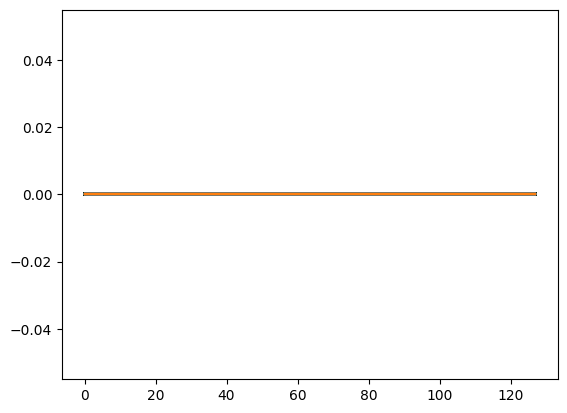

In [50]:
plt.plot(dNdt / dDdrydt)
plt.show()

In [36]:
true_gmean, true_gstd = ar.mean_std_diameter(true_dry_mass)
pred_gmean, pred_gstd = ar.mean_std_diameter(pred_dry_mass)

In [62]:
diams = np.logspace(-9,-6, true_gmean.shape[0])

In [89]:
Ddry[-1,:].shape

(1132,)

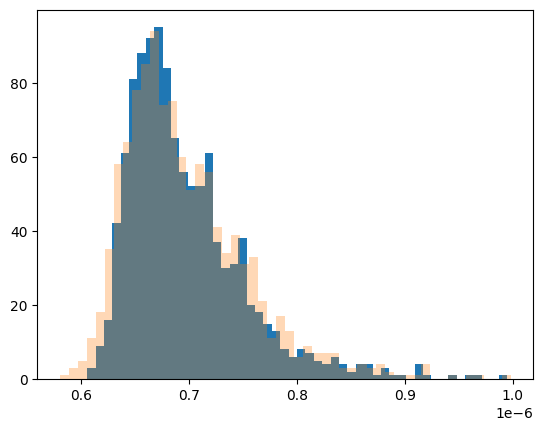

In [87]:
plt.hist(pred_Ddry[-1,:], bins=50)
plt.hist(true_Ddry[-1,:], bins=50, alpha=0.3)
plt.show()

In [88]:
def lognormal_distro(number_conc, diams, gmeans, gstds):
    return ((number_conc / (np.sqrt(2*np.pi) * np.log10(gstds))) * 
            np.exp(-0.5 * ((np.log10(diams) - np.log10(gmeans))**2 / (2 * np.log10(gstds)**2))))

In [98]:
true_nD = lognormal_distro(mat_prop['aero_number'], true_Ddry, true_gmean, true_gstd)
pred_nD = lognormal_distro(mat_prop['aero_number'], pred_Ddry, pred_gmean, pred_gstd)

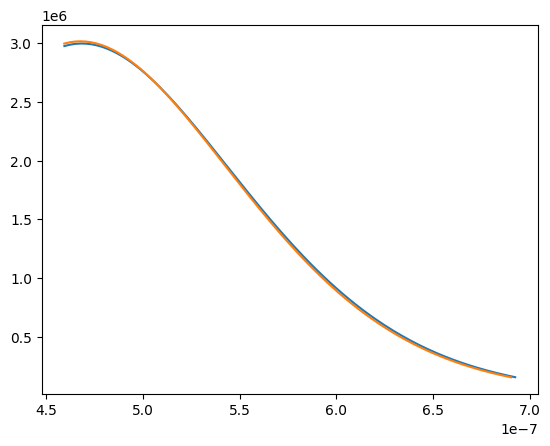

In [103]:
plt.plot(true_Ddry[:,150], true_nD[:,150])
plt.plot(pred_Ddry[:,150], pred_nD[:,150])
plt.show()

In [ ]:
# for i in range(0, true_drymass.shape[0], 10):
#     fig, ax = plt.subplots()
#     ax.hist(pred_drymass[i,:], bins=100)
#     ax.hist(true_drymass[i,:], bins=100, alpha=0.5)
#     plt.savefig(f"./figures/hists/hist{i}.png")
#     plt.close()